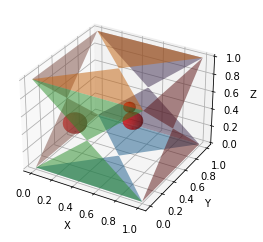

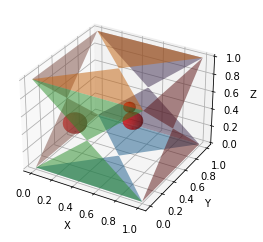

AttributeError: type object 'Element' has no attribute 'Ec'

In [1]:
import teee as te 
import math
from ClassElement import Element
from ClassDomain import Domain
from ClassModel import Model
from ClassInitialization import Initialization
import auxiliaryfunction as aux
import drawing as draw
#首先函数ParameterInit()需要初始化一类小球的参数

def ParameterInit():
    Element.Kn = 1
    Element.Kc = 1
    Element.m = Element.rho * 4/3 * Element.PI * Element.r * Element.r *Element.r #球的质量计算公式
    Element.I = 2/5 * Element.m * Element.r * Element.r             #实心球的转动惯量计算公式
#main函数是主要的执行逻辑

def main():
    #第一步生成计算区域
    #长方体中心
    center_point = [1,1,1]
    long = 2
    weight = 2
    height = 2
    domain = Domain(center_point,long,weight,height) 
                                                                                # print(domain.cuboid_vertices)
                                                                                # print(domain.normals)
                                                                                # print(domain.plane_points)
                                                                                
    #ParameterInit方法初始化一类小球静态参数：Kn,Kc,m,I
    ParameterInit()
    
    #为了给initialization传入参数,先生成坐标列表
    list_coord = aux.Generating_coordinate(Element.total_number,domain,Element.r)
    list_velocity = aux.Generating_velocity(Element.total_number)
    list_omega = aux.Generating_omega(Element.total_number)
    # 使用列表推导式提取每个子列表的第一个元素  
    first_elements = [sublist[0] for sublist in list_coord]  
    second_elements = [sublist[1] for sublist in list_coord]
    third_elements = [sublist[2] for sublist in list_coord]
    list_velx = list_velocity[0]
    list_vely = list_velocity[1]
    list_velz = list_velocity[2]
    list_omegax = list_omega[0]
    list_omegay = list_omega[1]
    list_omegaz = list_omega[2]
                                                                                # print(list_velocity)
                                                                                # print(len(list_velocity))   
                                                                                # print(list_omega)   
                                                                                # print(len(list_velocity))   

                                                                                # print(list_coord)
                                                                                # print(len(list_coord))
                                                                                # print(first_elements)
                                                                                # print(len(first_elements))
    #调用initialization类生成小球列表
    initialization = Initialization(first_elements,second_elements,third_elements,list_velx,list_vely,list_velz,list_omegax,list_omegay,list_omegaz)
    initialization.ElementListGnerate()
    element_list = initialization.element_list
    # print(element_list[0].m_velocity)
    # print([element_list[0].m_x,element_list[0].m_y,element_list[0].m_z]) 
    # print(element_list[1].m_velocity)
    # print([element_list[1].m_x,element_list[1].m_y,element_list[1].m_z]) 
    # print("分割")
                                                                                #print(initialization.element_list)
                                                                                #print(len(initialization.element_list))
    #生成模型类型，弹簧
    model_list = []
    for i in range(Element.total_number):
        for j in range(i+1,Element.total_number):
            model_list.append(Model(element_list[i],element_list[j]))
    print(len(element_list))
    for element in element_list:
            print("prex",element.m_z)
            print("prev",element.m_velx)


    #开始模拟
    time = 0.005                            #模拟总时长1s
    delta_time = Element.delta_time           #时间步长
    iter_count = int(time / delta_time)            #迭代次数 = 模拟总时长1s/时间步长
    """11个点,但是是10段线段,即10段过程。是从0开始,每次更新0.1s,直到更新10次到1"""
    #加速度，角加速度本质上已经再合力和合力矩里头了，这里声明临时变量算出他们
    acceleration_x = 0
    acceleration_y = 0
    acceleration_z = 0
    angular_acceleration_x = 0
    angular_acceleration_y = 0
    angular_acceleration_z = 0

    # 迭代过程,在每一个时间步上计算系统中所有小球的变化,即位置,速度,角速度的更新
    for i in range(iter_count): 
        """
        i=0就是:0时刻,
        for循环:从0号小球开始分析,0号小球初始状态位置,速度,角速度已经知道了,先计算力
            for循环:
                遍历其他小球以求出0号小球受到的合外力和合外力矩,最后计算加速度,角加速度,再更新速度。
                更新速度之后,就可以用新的速度更新位移了
        再进入下一个小球的分析,直至到最后一个小球,再进入下一时刻。
        """
        #第一层内循环遍历所有的小球，每次循环旨在完成对当前小球的受力分析
        for index1,element in enumerate(element_list):

            #第二层循环旨在遍历所有施力小球
            
            #先判断是否触及边界，如果是，则反弹
            if domain.rebound_sphere_from_cuboid(element):
                continue
            else:                   
                """
                 这里也许不需要遍历所小球，发生与受力分析粒子发生接触的粒子应该只在相邻位置w
                """
                for index2 in range(index1+1,Element.total_number):
                    D = aux.VectorMagnitude([element_list[index1].m_x                                                                                                                                   -element_list[index2].m_x,element_list[index1].m_y-element_list[index2].m_y,element_list[index1].m_z-element_list[index2].m_z])
                    #先用if判断具体的接触情况
                    if D > (element_list[index1].m_r + element_list[index2].m_r):     #球心间距比两球半径和要大，表示没有接触,跳过到下一个施力小球
                        continue
                    else : 
                    #球心间距比两球半径和要小，表示发生接触,调用CalContactForce来计算两个小球的接触力，并且分别存到小球对象的force_of_other以及torque_of_other属性的对应位置
                        element_list[index1].CalContactForce(element_list[index2],model_list[index1+index2-1]) #调用Elemnt的成员函数CalContactForce来计算接触力
            #内层循环已经计算完成了当前受力分析的小球所受的合外力以及合外力矩
            #这里把存在属性里的合外力和合外力矩累积到合外力属性
            element.CombinedF()
            element.CombinedTorque()
            
            #更新加速度,角加速度,根据牛顿第二定律和角动量定理
            acceleration_x = element.m_Fxsum/element.m_mass
            acceleration_y = element.m_Fysum / element.m_mass
            acceleration_z = element.m_Fzsum / element.m_mass
            angular_acceleration_x = element.m_Txsum / element.m_moment
            angular_acceleration_y = element.m_Tysum / element.m_moment
            angular_acceleration_z = element.m_Tzsum / element.m_moment

            #更新速度，和角速度
            element.m_velx += acceleration_x * delta_time
            element.m_vely += acceleration_y * delta_time
            element.m_velz += acceleration_z * delta_time
            element.m_omegax += angular_acceleration_x * delta_time
            element.m_omegay += angular_acceleration_y * delta_time
            element.m_omegaz += angular_acceleration_z * delta_time

            #更新位置
            element.m_x += element.m_velx * delta_time
            element.m_y += element.m_vely * delta_time
            element.m_z += element.m_velz * delta_time
            print("x",element.m_x)
            #print("v",element.m_velx)

            ax = te.plot_hexahedron(domain.point_for_draw)
            cx = [element.m_x for element in element_list]
            cy = [element.m_x for element in element_list]
            cz = [element.m_x for element in element_list]
            cc = [[x, y, z] for x, y, z in zip(cx, cy, cz)]
            radius_list = [element.m_r for element in element_list]
            te.plot_spheres(ax,cc,radius_list)
#当前主程序执行main()
main()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import math

# 创建一个新的图形
fig, ax = plt.subplots()

# 第一个球的参数
center1 = (1, 1)  # 球心坐标
radius1 = math.sqrt(2)/2     # 球半径
text1 = "Sphere 1"  # 第一个球的文字

# 第二个球的参数
center2 = (2, 2)  # 球心坐标
radius2 =  math.sqrt(2)/2   # 球半径
text2 = "Sphere 2"  # 第二个球的文字

# 绘制第一个球
circle1 = patches.Circle(center1, radius1, color='b', alpha=0.5)
ax.add_patch(circle1)

# 绘制第二个球
circle2 = patches.Circle(center2, radius2, color='r', alpha=0.5)
ax.add_patch(circle2)

# 在第一个球内写文字
ax.text(center1[0], center1[1], text1, ha='center', va='center', color='white')

# 在第二个球内写文字
ax.text(center2[0], center2[1], text2, ha='center', va='center', color='white')
# 添加箭头
arrow_start = (0.0,1.5)  # 箭头起点坐标
arrow_end = (2, 1.5)       # 箭头终点坐标
ax.annotate("", xy=arrow_end, xytext=arrow_start, arrowprops=dict(arrowstyle="->"))
# 设置图形的标题和坐标轴标签
ax.set_title('Two 2D Spheres with Text')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 设置坐标轴范围
ax.set_xlim(-2, 5)
ax.set_ylim(-2, 4)

# 隐藏网格
ax.grid(False)

# 显示图形
plt.axis('equal')
plt.show()
